In [1]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import supervision
import transformers
import pytorch_lightning

print(
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
torch:  2.1 ; cuda:  cu121
; supervision: 0.3.0 ; transformers: 4.35.2 ; pytorch_lightning: 2.1.2


In [40]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [41]:
import os
import torchvision


# settings
dataset_location = f"/mnt/d/Data/final/dataset"
ANNOTATION_FILE_NAME = "labels.json"
TEST_DIRECTORY = os.path.join(dataset_location, "test")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        dataset_directory_path: str,
        image_directory_path: str,
        image_processor,
        train: bool = False
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target
    
TEST_DATASET = CocoDetection(
    dataset_directory_path=f"{TEST_DIRECTORY}",
    image_directory_path=f"{TEST_DIRECTORY}//data",
    image_processor=image_processor,
    train=False)

print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of test examples: 2443


Image #267


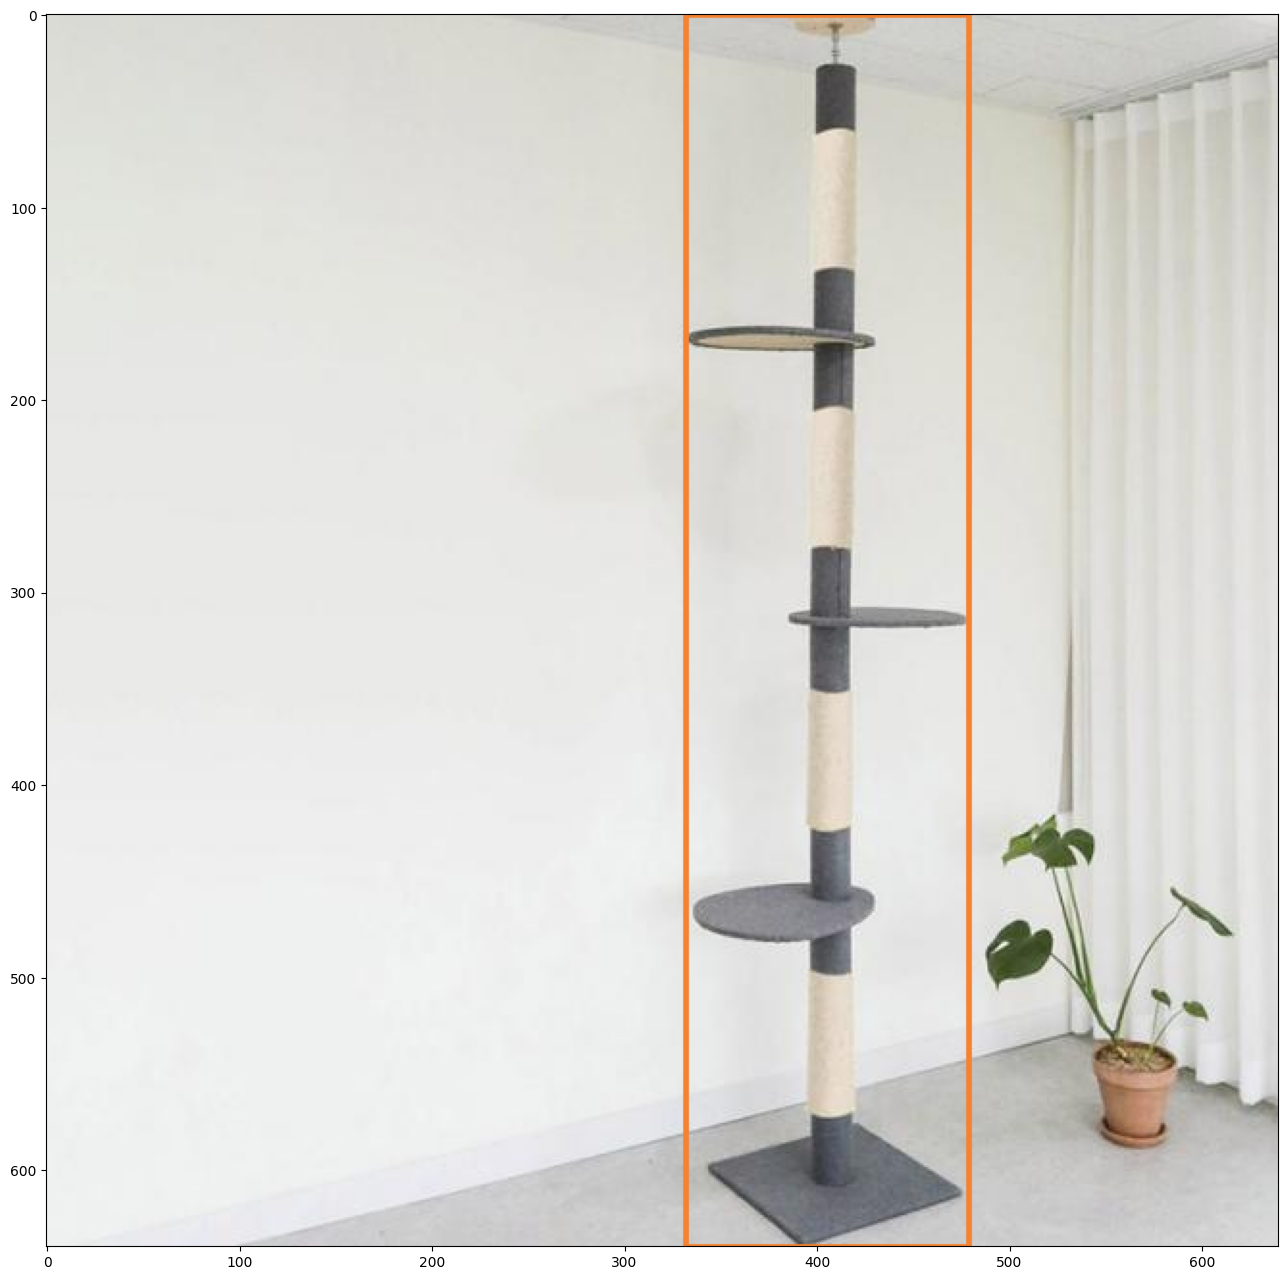

In [42]:
import random
import cv2
import numpy as np
import supervision as sv


# 랜덤 이미지 선택
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# 이미지, annotation 불러오기
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)


categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (16, 16))

In [43]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR 논문에서 훈련 중 다양한 이미지 크기를 사용했기 때문에 직접 배치를 구성할 수 없으므로, 
    # 가장 큰 해상도(min: 800, max: 1333)로 이미지를 패딩하고 실제 픽셀과 패딩 픽셀을 구분하는 이진 pixel_mask를 생성.

    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4, num_workers=8, pin_memory=True, persistent_workers=True)

In [44]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection, DetrForObjectDetection
import torch
import wandb


class Detr(pl.LightningModule):

    def __init__(self, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            revision = 'no_timm',
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return outputs

    def test_step(self, batch, batch_idx):
        outputs = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("test_loss", outputs.loss, on_step=True, on_epoch=True, logger=True)
        for k,v in outputs.loss_dict.items():
            self.log("test_" + k, v.item())

        # 예측
        pred_boxes = outputs.pred_boxes
        pred_logits = outputs.logits

        pred_probs = torch.softmax(pred_logits, dim=-1) #class probabilities
        max_probs, pred_labels = pred_probs.max(dim=-1) #max probabilities and corresponding num_of_labels

        threshold = 0.1 # confidence 최소값
        high_confidence_mask = max_probs > threshold
        filtered_pred_labels = pred_labels[high_confidence_mask]
        filtered_pred_boxes = pred_boxes[high_confidence_mask]

        # 정답
        labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]
        gt_boxes = [image_boxes["boxes"] for image_boxes in labels]
        gt_labels = [image_labels["class_labels"] for image_labels in labels]

        # 예측 좌표값[xc, yc, w, h] -> normalized COCO [xmin, ymin, w, h] 값으로 변환
        x_min = filtered_pred_boxes[:, 0] - (filtered_pred_boxes[:, 2] / 2)
        y_min = filtered_pred_boxes[:, 1] - (filtered_pred_boxes[:, 3] / 2)
        width = filtered_pred_boxes[:, 2]
        height = filtered_pred_boxes[:, 3]
        coco_format_pred_boxes = torch.stack((x_min, y_min, width, height), dim=1)

        # Calculate IoU
        def bbox_iou(box1, box2):
            """
            Calculate the Intersection over Union (IoU) of two bounding boxes.
            Boxes are in format [x_min, y_min, width, height].
            """
            # Calculate intersection, i.e., overlapping area
            x_left = torch.max(box1[..., 0], box2[..., 0])
            y_top = torch.max(box1[..., 1], box2[..., 1])
            x_right = torch.min(box1[..., 0] + box1[..., 2], box2[..., 0] + box2[..., 2])
            y_bottom = torch.min(box1[..., 1] + box1[..., 3], box2[..., 1] + box2[..., 3])

            intersection_area = torch.max(x_right - x_left, torch.zeros_like(x_right)) * \
                                torch.max(y_bottom - y_top, torch.zeros_like(y_bottom))

            # Calculate areas of each bbox
            box1_area = box1[..., 2] * box1[..., 3]
            box2_area = box2[..., 2] * box2[..., 3]

            # Calculate union area
            union_area = box1_area + box2_area - intersection_area

            # Compute IoU
            iou = intersection_area / union_area
            return iou

        def calculate_metrics(pred_boxes, pred_labels, gt_boxes, gt_labels, num_classes, iou_threshold=0.1):
            metrics = []
            for cls in range(num_classes):  # loop over all classes
                cls_pred_boxes = pred_boxes[pred_labels == cls]
                cls_gt_boxes = gt_boxes[gt_labels == cls]

                tp, fp, fn = 0, 0, len(cls_gt_boxes)
                for pred_box in cls_pred_boxes:
                    if len(cls_gt_boxes) == 0:
                        fp += 1
                        continue

                    ious = bbox_iou(pred_box.unsqueeze(0), cls_gt_boxes)
                    best_iou, best_index = ious.max(0)

                    if best_iou > iou_threshold:
                        tp += 1
                        cls_gt_boxes = torch.cat([cls_gt_boxes[:best_index], cls_gt_boxes[best_index + 1:]])
                    else:
                        fp += 1

                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                metrics.append((precision, recall, f1))

            return metrics
        
        batch_metrics = [calculate_metrics(pred_boxes, pred_labels, gt_boxes, gt_labels, num_classes=10) for pred_boxes, pred_labels, gt_boxes, gt_labels in zip(filtered_pred_boxes, filtered_pred_labels, gt_boxes, gt_labels)]
        flat_metrics = [metric for sublist in batch_metrics for metric in sublist]

        avg_precision = sum([m[0] for m in flat_metrics]) / len(flat_metrics)
        avg_recall = sum([m[1] for m in flat_metrics]) / len(flat_metrics)
        avg_f1 = sum([m[2] for m in flat_metrics]) / len(flat_metrics)

        self.log('val_avg_precision', avg_precision, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_avg_recall', avg_recall, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_avg_f1', avg_f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        
        # for cls in range(10):  # Assuming 10 classes
        #     self.log(f'val_precision_class_{cls}', avg_precision[cls], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #     self.log(f'val_recall_class_{cls}', avg_recall[cls], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #     self.log(f'val_f1_class_{cls}', avg_f1[cls], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return outputs.loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def test_dataloader(self):
        return TEST_DATALOADER

In [45]:
model = Detr()
ckpt_path = f"/mnt/c/Users/jhk16/PycharmProjects/Wise_Ad-/personal/JinhyunKim/Detection/DeTR/Models/DeTR_with_ResNet_RoI.pt" # backbone 바꾸기 테스트
ckpt = torch.load(ckpt_path)
model.state_dict(ckpt)

print(model)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([11, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

In [38]:
model.eval()

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

In [63]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(name="mixed_dataset_test_classification_6", project="DeTR-test", tags="test")

In [64]:
from pytorch_lightning import Trainer



# torch.set_float32_matmul_precision('medium')

# settings
MAX_EPOCHS = 50

trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, logger = wandb_logger)
trainer.test(model=model, dataloaders=TEST_DATALOADER, verbose=True)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 test_cardinality_error     0.6905900835990906
     test_loss_bbox        0.044806282967329025
      test_loss_ce          0.07368941605091095
     test_loss_epoch         0.432956337928772
     test_loss_giou         0.0676177367568016
    val_avg_f1_epoch      0.00010541505616856739
 val_avg_precision_epoch  0.00025518343318253756
  val_avg_recall_epoch     7.136138447094709e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁
test_cardinality_error,▁
test_loss_bbox,▁
test_loss_ce,▁
test_loss_epoch,▁
test_loss_giou,▁
test_loss_step,▂▁▃▃▂▂▂▄▄▂█▃▂▁▂▃▄▄▂▄▂▄▂▂▂▁▇▂▄▂▁▃▂▂▁▃▁▁▁▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_avg_f1_epoch,▁
val_avg_f1_step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_avg_precision_epoch,▁


In [48]:
wandb.finish()

In [46]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

In [48]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/611 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=1.78s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la